In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import umap

import seaborn as sns

from sklearn.datasets import make_classification, make_blobs
from sklearn.decomposition import PCA
from sklearn import mixture
from sklearn.metrics.cluster import adjusted_rand_score

#This needs to be initialized for UMAP repeatability
np.random.seed(15)

from sklearn.model_selection import train_test_split

In [2]:
from sklearn.model_selection import KFold

In [3]:
import datetime

In [4]:
def plot_without_clusters(df, ax):
    df.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'All df', c='black')
    ax.set_xlabel('Embedding Variable 1', fontsize = 22)
    ax.set_ylabel('Embedding Variable 2', fontsize = 22)
    #ax.legend(markerscale=5)
    ax.get_legend().remove()
    ax.set_title(f'Embedded/unlabled Data', fontsize = 22)

In [5]:
def plot_with_clusters(df, ax):    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for cluster, color in zip(df.y.unique(), colors):
        clust_df = df[df.y == cluster]
        clust_df.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'Cluster {cluster}', c=color)
        
    ax.set_xlabel('Embedding Variable 1', fontsize = 22)
    ax.set_ylabel('Embedding Variable 2', fontsize = 22)
    #ax.legend(markerscale=5)
    ax.get_legend().remove()
    ax.set_title(f'Ground Truth Data', fontsize = 22)

In [6]:
def plot_with_gmm_clusters(df, ax, n_clusters=4):
    true_labels = df.y.values
    df = df.drop(columns='y').copy()
    gmm = mixture.GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(df)
    pred_labels = gmm.predict(df)
    df['y'] = pred_labels
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for cluster, color in zip(range(n_clusters), colors):
        clust_df = df[df.y == cluster]
        clust_df.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'Cluster {cluster}', c=color)
    
    ax.set_xlabel('Embedding Variable 1', fontsize = 22)
    ax.set_ylabel('Embedding Variable 2', fontsize = 22)
    ax.legend(markerscale=5, loc=4)
    ax.set_title(f'Estimated Clusters', fontsize = 22)
    
    ax.text(
        0.05, 0.95,
        f'ARI = {adjusted_rand_score(true_labels, pred_labels):.2f}',
        transform=ax.transAxes,
        fontsize=14)

In [7]:
def plot_with_clusters_and_predicted(df, ax, n_clusters=4):
    true_labels = df.y.values
    pred_labels = df.pred.values
    df = df.drop(columns=['y', 'pred']).copy()
    df['y'] = pred_labels
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for cluster, color in zip(range(n_clusters), colors):
        clust_df = df[df.y == cluster]
        clust_df.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'Cluster {cluster}', c=color)
    
    ax.set_xlabel('Embedding Variable 1', fontsize = 22)
    ax.set_ylabel('Embedding Variable 2', fontsize = 22)
    ax.legend(markerscale=5, loc=4)
    ax.set_title(f'Estimated Clusters', fontsize = 22)
    
    ax.text(
        0.05, 0.95,
        f'ARI = {adjusted_rand_score(true_labels, pred_labels):.2f}',
        transform=ax.transAxes,
        fontsize=14)

## Setting class_sep at 0.75

In [8]:
X, y = make_classification(
    n_samples=100000, n_features=100, n_informative=50,
    n_redundant=0, n_repeated=0, n_classes=10,
    n_clusters_per_class=1, random_state=12,
    class_sep = 0.75
)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 31415
)

In [10]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)
ump_train_emb_list = []
ump_test_emb_list = []

pca_train_emb_list = []
pca_test_emb_list = []

In [11]:
i = 0
for train_index, _ in kf.split(X_train):
    X_train_fold = pd.DataFrame(X_train).iloc[train_index]
    X_train_fold, X_test_fold = X_train_fold.copy(), X_test.copy()
    
    ebd = umap.UMAP(random_state=i)
    pca = PCA(n_components=2)
    
    ump_train_emb_list.append(ebd.fit_transform(X_train_fold))
    pca_train_emb_list.append(pca.fit_transform(X_train_fold))
    print(f'{datetime.datetime.now()}--- Fold {i} train embedding complete.')
    
    ump_test_emb_list.append(ebd.transform(X_test_fold))
    pca_test_emb_list.append(pca.transform(X_test_fold))
    print(f'{datetime.datetime.now()}--- Fold {i} test embedding complete.')
    
    i = i+1

2019-04-05 15:33:28.053096--- Fold 0 train embedding complete.
2019-04-05 15:34:01.775758--- Fold 0 test embedding complete.
2019-04-05 15:36:43.330278--- Fold 1 train embedding complete.
2019-04-05 15:37:05.306239--- Fold 1 test embedding complete.
2019-04-05 15:39:41.704344--- Fold 2 train embedding complete.
2019-04-05 15:40:03.288066--- Fold 2 test embedding complete.
2019-04-05 15:42:38.980737--- Fold 3 train embedding complete.
2019-04-05 15:43:00.985990--- Fold 3 test embedding complete.
2019-04-05 15:45:34.240870--- Fold 4 train embedding complete.
2019-04-05 15:45:57.803855--- Fold 4 test embedding complete.


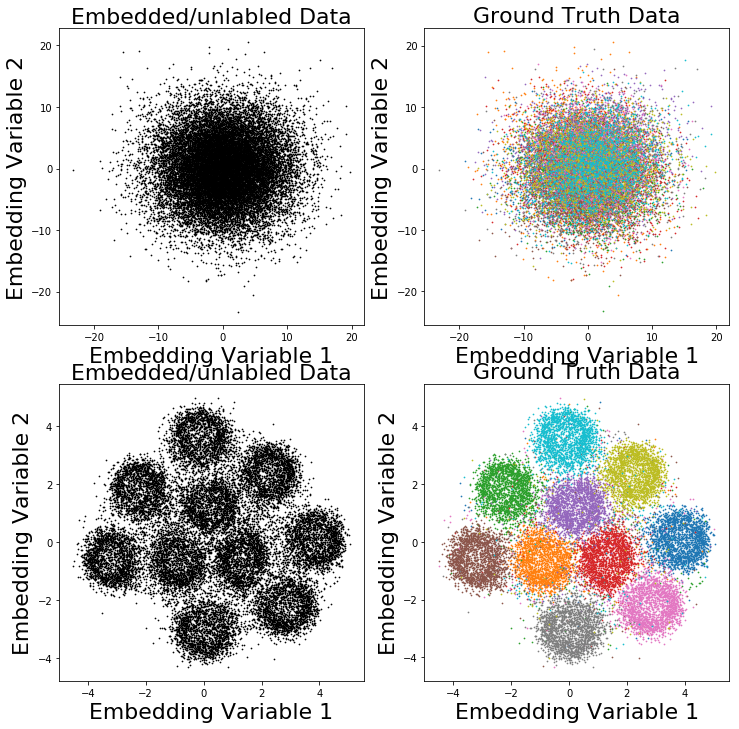

In [12]:
f, _ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
ax = _ax.flatten()

X_PCA = pd.DataFrame(pca_test_emb_list[-1])
X_PCA['y'] = y_test
X_Uy = pd.DataFrame(ump_test_emb_list[-1])
X_Uy['y'] = y_test

plot_without_clusters(X_PCA, ax[0])
plot_with_clusters(X_PCA, ax[1])
#plot_with_gmm_clusters(X_PCA, ax[2], n_clusters=10)

plot_without_clusters(X_Uy, ax[2])
plot_with_clusters(X_Uy, ax[3])
#plot_with_gmm_clusters(X_Uy, ax[5], n_clusters=10)

Text(0.5, 1.0, 'Unlabeled Data')

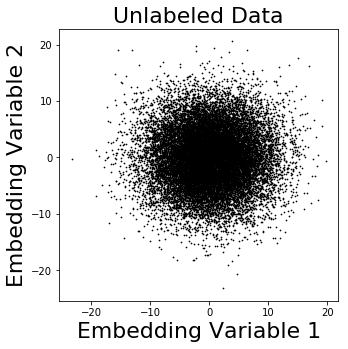

In [13]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

X_PCA.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'All df', c='black')
ax.set_xlabel('Embedding Variable 1', fontsize = 22)
ax.set_ylabel('Embedding Variable 2', fontsize = 22)
#ax.legend(markerscale=5)
ax.get_legend().remove()
ax.set_title(f'Unlabeled Data', fontsize = 22)

#plot_without_clusters(X_PCA, ax)

Text(0.5, 1.0, 'Ground Truth Labels')

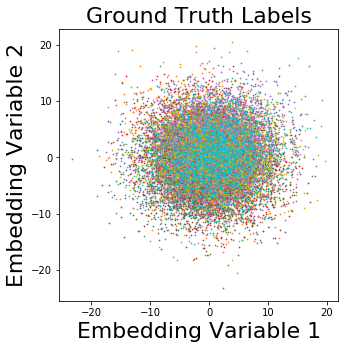

In [14]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for cluster, color in zip(X_PCA.y.unique(), colors):
    clust_df = X_PCA[X_PCA.y == cluster]
    clust_df.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'Cluster {cluster}', c=color)
    
ax.set_xlabel('Embedding Variable 1', fontsize = 22)
ax.set_ylabel('Embedding Variable 2', fontsize = 22)
#ax.legend(markerscale=5)
ax.get_legend().remove()
ax.set_title(f'Ground Truth Labels', fontsize = 22)

In [15]:
y_test.shape

(20000,)

In [16]:
len(pca_test_emb_list)

5

In [17]:
pca_test_emb_list[-1].shape

(20000, 2)

## Build GMM on each synthetic embedding fold

In [18]:
pca_pwise_ari = []
pca_true_ari = []
for n_components in range(2,20):
    pca_pred_labels = []
    for train, test in zip(pca_train_emb_list, pca_test_emb_list):
        gmm = mixture.GaussianMixture(n_components=n_components, random_state=17)
        gmm.fit(train)
        pca_pred_labels.append(gmm.predict(test))
        
    pca_pairwise_ari_vals = []
    ari_to_true = []
    for i in range(len(pca_pred_labels)):
        for j in range(i):
            pca_pairwise_ari_vals.append(adjusted_rand_score(pca_pred_labels[i], pca_pred_labels[j]))
        ari_to_true.append(adjusted_rand_score(pca_pred_labels[i], y_test))
    pca_pwise_ari.append(np.mean(pca_pairwise_ari_vals))
    pca_true_ari.append(np.mean(ari_to_true))
    
    print(f'Given {n_components:2} clusters, the mean pairwise ARI is {pca_pwise_ari[-1]:.3f}. (ARI to true of {pca_true_ari[-1]:.3f})')

Given  2 clusters, the mean pairwise ARI is 0.679. (ARI to true of 0.002)
Given  3 clusters, the mean pairwise ARI is 0.306. (ARI to true of 0.008)
Given  4 clusters, the mean pairwise ARI is 0.318. (ARI to true of 0.008)
Given  5 clusters, the mean pairwise ARI is 0.192. (ARI to true of 0.007)
Given  6 clusters, the mean pairwise ARI is 0.308. (ARI to true of 0.007)
Given  7 clusters, the mean pairwise ARI is 0.246. (ARI to true of 0.007)
Given  8 clusters, the mean pairwise ARI is 0.235. (ARI to true of 0.006)
Given  9 clusters, the mean pairwise ARI is 0.221. (ARI to true of 0.007)
Given 10 clusters, the mean pairwise ARI is 0.226. (ARI to true of 0.007)
Given 11 clusters, the mean pairwise ARI is 0.209. (ARI to true of 0.007)
Given 12 clusters, the mean pairwise ARI is 0.190. (ARI to true of 0.006)
Given 13 clusters, the mean pairwise ARI is 0.188. (ARI to true of 0.006)
Given 14 clusters, the mean pairwise ARI is 0.185. (ARI to true of 0.006)
Given 15 clusters, the mean pairwise A

In [19]:
pca_ari = pd.DataFrame(index=range(2,20))
pca_ari['pairwise'] = pca_pwise_ari
pca_ari['true'] = pca_true_ari

In [20]:
pca_ari

,pairwise,true
2,0.678609,0.002479
3,0.305618,0.007708
4,0.318444,0.007624
5,0.191830,0.007484
6,0.308295,0.006801
7,0.245899,0.006732
8,0.234835,0.006420
9,0.221313,0.006736
10,0.226099,0.006862
11,0.209226,0.006609


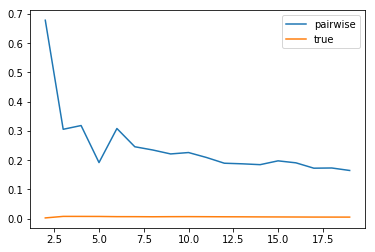

In [21]:
pca_ari.plot()

In [22]:
df = pd.DataFrame(pca_test_emb_list[-1])
df['y'] = y_test
n_clusters = 2

pca_pred_labels = []
for train, test in zip(pca_train_emb_list, pca_test_emb_list):
    gmm = mixture.GaussianMixture(n_components=n_clusters, random_state=17)
    gmm.fit(train)
    pca_pred_labels.append(gmm.predict(test))
    
pca_pairwise_ari_vals = []
ari_to_true = []
for i in range(len(pca_pred_labels)):
    for j in range(i):
        pca_pairwise_ari_vals.append(adjusted_rand_score(pca_pred_labels[i], pca_pred_labels[j]))
    ari_to_true.append(adjusted_rand_score(pca_pred_labels[i], y_test))
mean_pca_pairwise_ari = np.mean(pca_pairwise_ari_vals)
mean_ari_to_true = np.mean(ari_to_true)

"ax.text(\n    0.05, 0.95,\n    f'Mean Pairwise ARI = {mean_pca_pairwise_ari:.2f}',\n    transform=ax.transAxes,\n    fontsize=14)\n\nax.text(\n    0.05, 0.85,\n    f'Mean ARI to Ground Truth = {mean_ari_to_true:.2f}',\n    transform=ax.transAxes,\n    fontsize=14)"

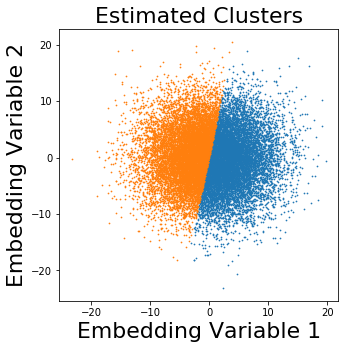

In [23]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

true_labels = df.y.values
df = df.drop(columns='y').copy()
#gmm = mixture.GaussianMixture(n_components=n_clusters, random_state=42)
#gmm.fit(df)
pred_labels = gmm.predict(df)
df['y'] = pred_labels

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for cluster, color in zip(range(n_clusters), colors):
    clust_df = df[df.y == cluster]
    clust_df.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'Cluster {cluster}', c=color)

ax.set_xlabel('Embedding Variable 1', fontsize = 22)
ax.set_ylabel('Embedding Variable 2', fontsize = 22)
ax.legend(markerscale=5, loc=4)
ax.get_legend().remove()
ax.set_title(f'Estimated Clusters', fontsize = 22)

'''ax.text(
    0.05, 0.95,
    f'Mean Pairwise ARI = {mean_pca_pairwise_ari:.2f}',
    transform=ax.transAxes,
    fontsize=14)

ax.text(
    0.05, 0.85,
    f'Mean ARI to Ground Truth = {mean_ari_to_true:.2f}',
    transform=ax.transAxes,
    fontsize=14)'''

## Repeat with UMAP Embedding

In [24]:
for n_components in range(2,20):
    ump_pred_labels = []
    for train, test in zip(ump_train_emb_list, ump_test_emb_list):
        gmm = mixture.GaussianMixture(n_components=n_components, random_state=17)
        gmm.fit(train)
        ump_pred_labels.append(gmm.predict(test))
        
    ump_pairwise_ari_vals = []
    ari_to_true = []
    for i in range(len(ump_pred_labels)):
        for j in range(i):
            ump_pairwise_ari_vals.append(adjusted_rand_score(ump_pred_labels[i], ump_pred_labels[j]))
        ari_to_true.append(adjusted_rand_score(ump_pred_labels[i], y_test))
    mean_ump_pairwise_ari = np.mean(ump_pairwise_ari_vals)
    mean_ari_to_true = np.mean(ari_to_true)
    
    print(f'Given {n_components:2} clusters, the mean pairwise ARI is {mean_ump_pairwise_ari:.3f}. (ARI to true of {mean_ari_to_true:.3f})')

Given  2 clusters, the mean pairwise ARI is 0.242. (ARI to true of 0.149)
Given  3 clusters, the mean pairwise ARI is 0.223. (ARI to true of 0.260)
Given  4 clusters, the mean pairwise ARI is 0.322. (ARI to true of 0.342)
Given  5 clusters, the mean pairwise ARI is 0.340. (ARI to true of 0.413)
Given  6 clusters, the mean pairwise ARI is 0.453. (ARI to true of 0.504)
Given  7 clusters, the mean pairwise ARI is 0.485. (ARI to true of 0.586)
Given  8 clusters, the mean pairwise ARI is 0.540. (ARI to true of 0.642)
Given  9 clusters, the mean pairwise ARI is 0.596. (ARI to true of 0.724)
Given 10 clusters, the mean pairwise ARI is 0.733. (ARI to true of 0.812)
Given 11 clusters, the mean pairwise ARI is 0.690. (ARI to true of 0.788)
Given 12 clusters, the mean pairwise ARI is 0.645. (ARI to true of 0.759)
Given 13 clusters, the mean pairwise ARI is 0.649. (ARI to true of 0.763)
Given 14 clusters, the mean pairwise ARI is 0.614. (ARI to true of 0.735)
Given 15 clusters, the mean pairwise A

In [25]:
ump_pwise_ari = []
ump_true_ari = []
for n_components in range(2,20):
    ump_pred_labels = []
    for train, test in zip(ump_train_emb_list, ump_test_emb_list):
        gmm = mixture.GaussianMixture(n_components=n_components, random_state=17)
        gmm.fit(train)
        ump_pred_labels.append(gmm.predict(test))
        
    ump_pairwise_ari_vals = []
    ari_to_true = []
    for i in range(len(ump_pred_labels)):
        for j in range(i):
            ump_pairwise_ari_vals.append(adjusted_rand_score(ump_pred_labels[i], ump_pred_labels[j]))
        ari_to_true.append(adjusted_rand_score(ump_pred_labels[i], y_test))
    ump_pwise_ari.append(np.mean(ump_pairwise_ari_vals))
    ump_true_ari.append(np.mean(ari_to_true))
    
    print(f'Given {n_components:2} clusters, the mean pairwise ARI is {ump_pwise_ari[-1]:.3f}. (ARI to true of {ump_true_ari[-1]:.3f})')

Given  2 clusters, the mean pairwise ARI is 0.242. (ARI to true of 0.149)
Given  3 clusters, the mean pairwise ARI is 0.223. (ARI to true of 0.260)
Given  4 clusters, the mean pairwise ARI is 0.322. (ARI to true of 0.342)
Given  5 clusters, the mean pairwise ARI is 0.340. (ARI to true of 0.413)
Given  6 clusters, the mean pairwise ARI is 0.453. (ARI to true of 0.504)
Given  7 clusters, the mean pairwise ARI is 0.485. (ARI to true of 0.586)
Given  8 clusters, the mean pairwise ARI is 0.540. (ARI to true of 0.642)
Given  9 clusters, the mean pairwise ARI is 0.596. (ARI to true of 0.724)
Given 10 clusters, the mean pairwise ARI is 0.733. (ARI to true of 0.812)
Given 11 clusters, the mean pairwise ARI is 0.690. (ARI to true of 0.788)
Given 12 clusters, the mean pairwise ARI is 0.645. (ARI to true of 0.759)
Given 13 clusters, the mean pairwise ARI is 0.649. (ARI to true of 0.763)
Given 14 clusters, the mean pairwise ARI is 0.614. (ARI to true of 0.735)
Given 15 clusters, the mean pairwise A

In [26]:
ump_ari = pd.DataFrame(index=range(2,20))
ump_ari['pairwise'] = ump_pwise_ari
ump_ari['true'] = ump_true_ari

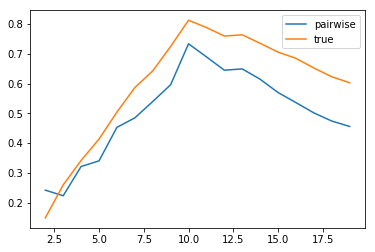

In [27]:
ump_ari.plot()

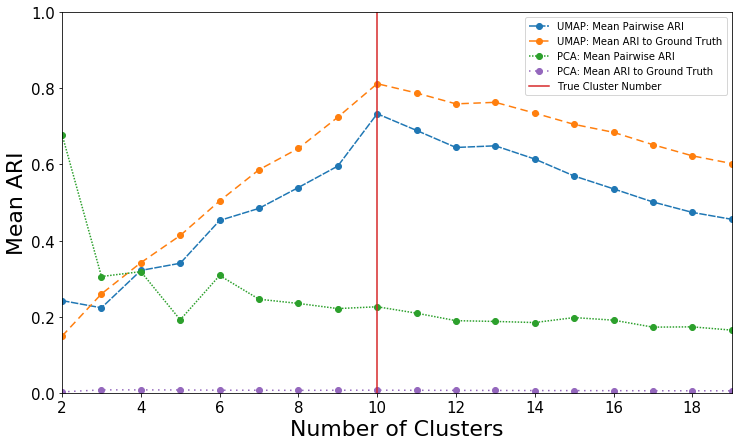

In [28]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))

ax.plot(ump_ari.pairwise, 'o', linestyle=(0, (5, 1)), color='C0', label='UMAP: Mean Pairwise ARI')
ax.plot(ump_ari.true    , 'o', linestyle=(0, (5, 3)),  color='C1', label='UMAP: Mean ARI to Ground Truth')
ax.plot(pca_ari.pairwise, 'o', linestyle=(0, (1, 1)), color='C2', label='PCA: Mean Pairwise ARI')
ax.plot(pca_ari.true    , 'o', linestyle=(0, (1, 3)),  color='C4', label='PCA: Mean ARI to Ground Truth')

ax.axvline(10, label='True Cluster Number', color='C3')

ax.set_xlim(2,19)
ax.set_ylim(0,1)
ax.set_ylabel('Mean ARI'          , fontsize=22)
ax.set_xlabel('Number of Clusters', fontsize=22)

ax.tick_params(axis='both', labelsize=15)

ax.legend()

In [29]:
X_UMAP = pd.DataFrame(ump_test_emb_list[-1])
X_UMAP['y'] = y_test

Text(0.5, 1.0, 'Unlabeled Data')

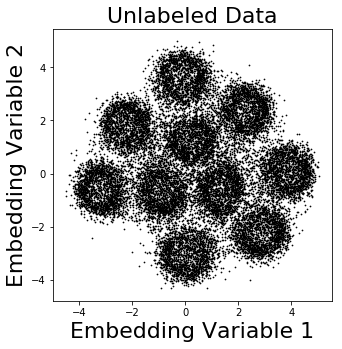

In [30]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

X_UMAP.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'All df', c='black')
ax.set_xlabel('Embedding Variable 1', fontsize = 22)
ax.set_ylabel('Embedding Variable 2', fontsize = 22)
#ax.legend(markerscale=5)
ax.get_legend().remove()
ax.set_title(f'Unlabeled Data', fontsize = 22)

#plot_without_clusters(X_UMAP, ax)

Text(0.5, 1.0, 'Ground Truth Labels')

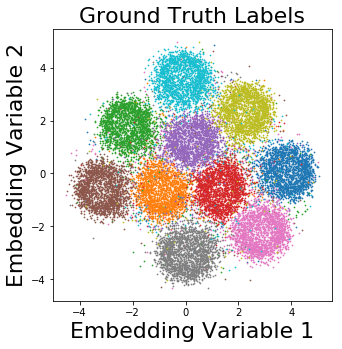

In [31]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for cluster, color in zip(X_UMAP.y.unique(), colors):
    clust_df = X_UMAP[X_UMAP.y == cluster]
    clust_df.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'Cluster {cluster}', c=color)
    
ax.set_xlabel('Embedding Variable 1', fontsize = 22)
ax.set_ylabel('Embedding Variable 2', fontsize = 22)
#ax.legend(markerscale=5)
ax.get_legend().remove()
ax.set_title(f'Ground Truth Labels', fontsize = 22)

In [32]:

df = pd.DataFrame(ump_test_emb_list[-1])
df['y'] = y_test
n_clusters = 10

In [33]:
ump_pred_labels = []
for train, test in zip(ump_train_emb_list, ump_test_emb_list):
    gmm = mixture.GaussianMixture(n_components=n_clusters, random_state=17)
    gmm.fit(train)
    ump_pred_labels.append(gmm.predict(test))
    
ump_pairwise_ari_vals = []
ari_to_true = []
for i in range(len(ump_pred_labels)):
    for j in range(i):
        ump_pairwise_ari_vals.append(adjusted_rand_score(ump_pred_labels[i], ump_pred_labels[j]))
    ari_to_true.append(adjusted_rand_score(ump_pred_labels[i], y_test))
mean_ump_pairwise_ari = np.mean(ump_pairwise_ari_vals)
mean_ari_to_true = np.mean(ari_to_true)

In [34]:
ump_pairwise_ari_vals

[0.7844906531217887,
 0.7818947265976852,
 0.7823234557523725,
 0.6574858682814884,
 0.658727076267515,
 0.6541248562274505,
 0.7831646359208586,
 0.7881360024048387,
 0.7857844194882722,
 0.6573382163739323]

In [35]:
true_labels = df.y.values
df = df.drop(columns='y').copy()
#gmm = mixture.GaussianMixture(n_components=n_clusters, random_state=42)
#gmm.fit(df)
pred_labels = gmm.predict(df)
df['y'] = pred_labels

"ax.text(\n    0.05, 0.95,\n    f'Mean Pairwise ARI = {mean_ump_pairwise_ari:.2f}',\n    transform=ax.transAxes,\n    fontsize=14)\n\nax.text(\n    0.05, 0.85,\n    f'Mean ARI to Ground Truth = {mean_ari_to_true:.2f}',\n    transform=ax.transAxes,\n    fontsize=14)"

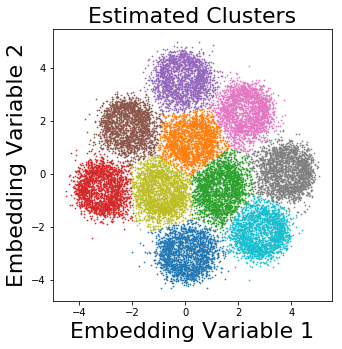

In [36]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for cluster, color in zip(range(n_clusters), colors):
    clust_df = df[df.y == cluster]
    clust_df.plot.scatter(x = 0, y = 1, s = 0.5, ax=ax, label=f'Cluster {cluster}', c=color)

ax.set_xlabel('Embedding Variable 1', fontsize = 22)
ax.set_ylabel('Embedding Variable 2', fontsize = 22)
ax.legend(markerscale=5, loc=4)
ax.get_legend().remove()
ax.set_title(f'Estimated Clusters', fontsize = 22)

'''ax.text(
    0.05, 0.95,
    f'Mean Pairwise ARI = {mean_ump_pairwise_ari:.2f}',
    transform=ax.transAxes,
    fontsize=14)

ax.text(
    0.05, 0.85,
    f'Mean ARI to Ground Truth = {mean_ari_to_true:.2f}',
    transform=ax.transAxes,
    fontsize=14)'''